In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

td = pd.read_csv("./data/zillow/train_2016.csv", parse_dates=["transactiondate"])
test_panda = td[1:4]
print(test_panda.sum().reset_index())

      index             0
0  parcelid  3.910822e+07
1  logerror -1.506000e-01


Now that we opened the training data, let's explore it's contents

Parcelid serve's as a key to a more detailed properties data, which we will explore later
logerror is what we need to predict as part of this competition.
For further information, please read the competition rules.

Let's explore the transaction date to see the distribution of trasactions in 2016
We will need a little python helper magic to parse the data and visualize it with good old seaborn

count                   90811
unique                    352
top       2016-04-29 00:00:00
freq                      917
first     2016-01-01 00:00:00
last      2016-12-30 00:00:00
Name: transactiondate, dtype: object


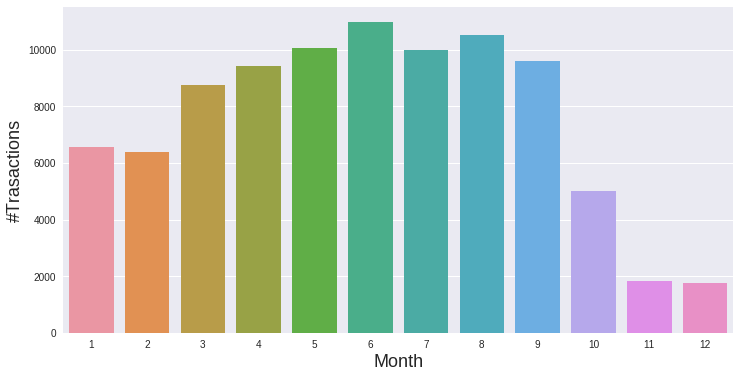

In [2]:
#print the column IDs
#print(td.columns)
#print the first 5 rows in the training data
#print(td.head())
print(td["transactiondate"].describe(include=[np.number]))
td["transactionmonth"] = td["transactiondate"].dt.month
td["transactionyear"] = td["transactiondate"].dt.year


cnt_srs = td["transactionmonth"].value_counts()
# print(cnt_srs)
%matplotlib inline
plt.figure(figsize=(12,6))
sb.barplot(cnt_srs.index, cnt_srs.values)
plt.xlabel("Month", fontsize=18)
plt.ylabel("#Trasactions", fontsize=18)
plt.show()

In [3]:
pdata = pd.read_csv("./data/zillow/properties_2016.csv")
psmall = pdata[1:100]

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2985217, 58)
(42,)


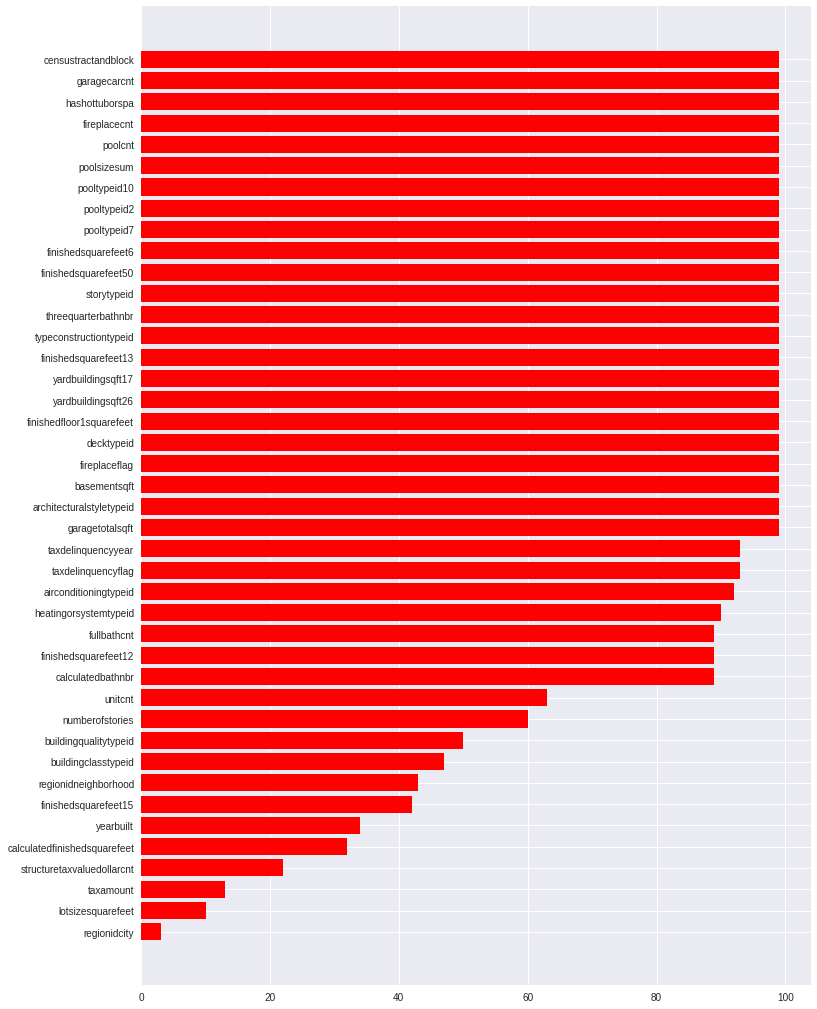

In [4]:
print(pdata.shape)
#print(psmall.columns)
#print(psmall)
ndata = psmall.isnull().sum(axis=0).reset_index()
ndata.columns = ["column_name", "missing_count"]
ndata = ndata.loc[ndata["missing_count"] > 0]
ndata = ndata.sort_values(by="missing_count")
ind = np.arange(ndata.shape[0])
width = 0.8
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, ndata.missing_count.values, color='red')
ax.set_yticks(ind)

num_cols = ndata.column_name.values.shape[0]
new_cols = ndata.column_name.values.reshape(num_cols)
print(new_cols.shape)
ax.set_yticklabels(new_cols, rotation='horizontal')
plt.show()
# print(ind)

### Bivariate Analysis ?

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

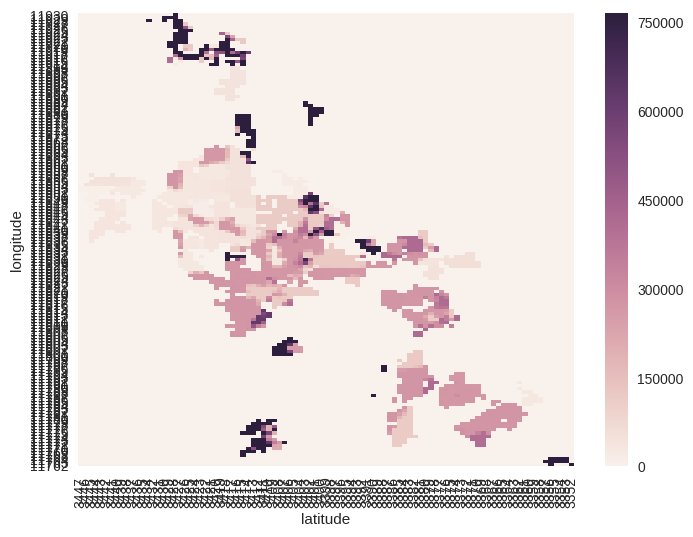

In [237]:
import cufflinks as cf
import plotly.plotly as py
pdm = pd.merge(pdata, td, on='parcelid')
var1_name = "calculatedfinishedsquarefeet"
var2_name = "logerror"
data1 = pdm[var1_name]
data2 = pdm[var2_name]
limit = 20
print(pdm.columns)

-
    
# geo_plot(pdm, 'latitude', 'longitude', 'regionidcounty')
geo_plot(pdm, 'latitude', 'longitude', 'regionidneighborhood', use_log=0)

In [235]:
#plt.scatter(pdm_small['latitude'],pdm_small['longitude'])
print(pdm_small.regionidneighborhood)
#print(pdm['transactionmonth'].value_counts())
#sb.boxplot(x='transactionmonth', y='logerror', data=pdm)
#ax.scatter(pdm['latitude'], pdm['longitude'], pdm['calculatedfinishedsquarefeet'])
#cols = pdata.columns
#print(cols)
plt.show()

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26        48570.0
27       268588.0
28       268588.0
29        48570.0
           ...   
90245         NaN
90246    114246.0
90247         NaN
90248    268118.0
90249         NaN
90250         NaN
90251         NaN
90252         NaN
90253         NaN
90254         NaN
90255    417225.0
90256         NaN
90257    268118.0
90258         NaN
90259    268118.0
90260         NaN
90261         NaN
90262     32059.0
90263    116206.0
90264    275405.0
90265     21056.0
90266     22655.0
90267         NaN
90268         NaN
90269    2

In [233]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

limit = 5000
#train = pdm[0:limit]
train = pdm
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("logerror")
numerical_features = numerical_features.drop("transactiondate")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
y = train['logerror']
#train['latitude'] = np.log(train['latitude'])
#train['longitude'] = np.log(train['longitude'])
#numerical_features = ['calculatedfinishedsquarefeet', 'latitude', 'longitude', 'garagetotalsqft', 'regionidneighborhood' ]
#numerical_features = ['calculatedfinishedsquarefeet', 'garagetotalsqft', 'transactionmonth', 'yearbuilt' ]

print(numerical_features)
train_num = train[numerical_features]
train_cat = train[categorical_features]


# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train_num, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train = X_train
y_train = y_train

xgb_model = xgb.XGBRegressor(max_depth=6, n_estimators=1000).fit(X_train, y_train, eval_metric='rmse')
#X_test = X_train
#y_test = y_train
predictions = xgb_model.predict(X_test)
actuals = y_test
#diff = np.concatenate(actuals.values, predictions)
actuals = actuals.values
print(actuals.shape)
print(predictions.shape)
#for i in range(predictions.shape[0]):
    #print(predictions[i], actuals[i])
#print(predictions)
#print(actuals)
#print(diff)
#print(predictions)
print(mean_squared_error(actuals, predictions))

Numerical features : 54
Categorical features : 5
Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
    